# Setup

In [ ]:
import torch
import requests
import numpy as np
import torchvision
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from fastcore.all import *
from miniai.learner import *

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [ ]:
# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Getting Features from VGG16

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device).features

In [ ]:
def calc_features(imgs, target_layers=[18, 25]): 
    mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
    std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
    x = (imgs-mean) / std
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            h, w = x.shape[-2:]
            feats.append(x.clone())
    return feats

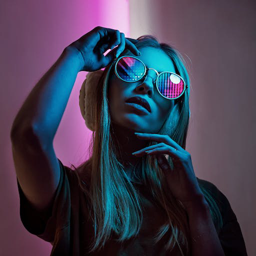

In [ ]:
content_image = download_image("https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?auto=compress&cs=tinysrgb&w=512")
content_image = content_image.resize((256, 256))
content_image

In [ ]:
content_img_tensor = T.ToTensor()(content_image).unsqueeze(0).to(device)
with torch.no_grad(): feats = calc_features(content_img_tensor)
[f.shape for f in feats]

[torch.Size([1, 512, 32, 32]), torch.Size([1, 512, 16, 16])]

## Style Loss: Gram Matrix Version

Ask ChatGPT: In the context of style transfer, a gram matrix is a mathematical representation of the style of an image. It is typically used to measure the style similarity between two images, with a higher gram matrix similarity indicating a greater style similarity.

A gram matrix is calculated by taking the dot product of a matrix of the feature maps of a convolutional neural network (CNN) with itself. The feature maps are usually obtained from one of the hidden layers of the CNN, and they capture different aspects of the image content at different scales.

To calculate the gram matrix, the feature maps are first reshaped into a matrix, with the feature maps corresponding to different locations in the image being arranged in rows and the different feature maps being arranged in columns. The gram matrix is then obtained by taking the dot product of this matrix with itself.

The resulting gram matrix is a square matrix with dimensions equal to the number of feature maps. Each element of the gram matrix represents the dot product of a pair of feature maps, and the values of the elements capture the correlations between different feature maps.

In [ ]:
def calc_styles(imgs):
    grams = []
    for x in calc_features(imgs, target_layers=[1, 6, 11, 18, 25]):
        h, w = x.shape[-2:]
        gram = torch.einsum('bchw, bdhw -> bcd', x, x) / (h*w)
        grams.append(gram)
    return grams

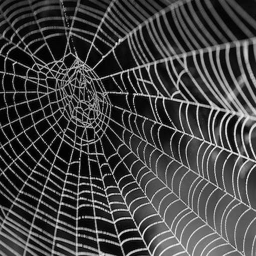

In [ ]:
style_image = download_image("https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?auto=compress&cs=tinysrgb&w=512")
style_image = style_image.resize((256, 256))
style_image

In [ ]:
style_img_tensor = T.ToTensor()(style_image).unsqueeze(0).to(device)
with torch.no_grad():
    style_grams = calc_styles(style_img_tensor)
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512])]

In [ ]:
def calc_style_loss(grams_x, grams_y):
    loss = 0.0
    for x, y in zip(grams_x, grams_y):
        loss = loss + (x-y).square().mean()
    return loss

In [ ]:
with torch.no_grad():
    loss = calc_style_loss(calc_styles(content_img_tensor), calc_styles(style_img_tensor))
loss

tensor(356.1602, device='cuda:0')

## Style Transfer

In [ ]:
class DummyDataset(Dataset):
    def __init__(self, length=1, x=0, y=0): store_attr('length,x,y')
    def __len__(self): return self.length
    def __getitem__(self, idx): return self.x, self.y

def get_dummy_dls(length=100):
    dl = DataLoader(DummyDataset(length=length), batch_size=1)
    valid_dl = DataLoader(DummyDataset(length=1), batch_size=1)
    return DataLoaders(dl, valid_dl)

In [ ]:
class PixelGenerator(nn.Module):
    """A tensor of shape [1, 3, size, size] to represent an image"""
    def __init__(self, size=256, init_image_tensor=None):
        super(PixelGenerator, self).__init__()
        self.im_array = nn.Parameter(torch.rand(1, 3, size, size))
        if init_image_tensor != None:
            self.im_array = nn.Parameter(init_image_tensor.clone())

    def forward(self):
        return self.im_array

In [ ]:
class StyleLossCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, style_img_tensor, content_img_tensor, style_loss_scale=1):
        store_attr()
        with torch.no_grad():
            self.style_target_grams = calc_styles(style_img_tensor)
            self.content_target_features = calc_features(content_img_tensor)
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): 
        output_grams = calc_styles(self.learn.preds)
        style_loss = calc_style_loss(output_grams, self.style_target_grams)
        output_features = calc_features(self.learn.preds)
        content_loss = sum([self.learn.loss_func(f1, f2) for f1, f2 in zip(output_features, self.content_target_features)])
        learn.loss = style_loss * self.style_loss_scale + content_loss
    def before_fit(self, learn): self.learn=learn 
    def after_fit(self, learn): plt.imshow(model()[0].detach().permute(1, 2, 0).cpu().clip(0, 1));

In [ ]:
model = PixelGenerator(init_image_tensor = content_img_tensor).to(device)
cbs = [StyleLossCB(style_img_tensor, content_img_tensor, 1), ProgressCB(), MetricsCB()]
learn = Learner(model, get_dummy_dls(100), nn.MSELoss(), lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
78.908,0,train
44.590,0,eval


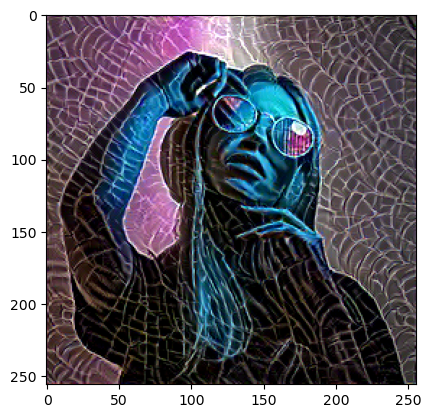

In [ ]:
learn.fit(1)

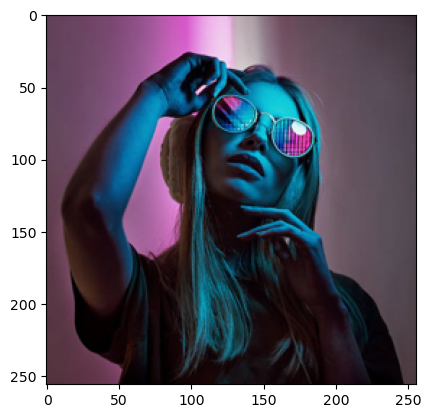

In [ ]:
# Comparing to the original:
plt.imshow(content_img_tensor.squeeze().permute(1, 2, 0).cpu().clip(0, 1));